## Extract depth map

In [3]:
import torch
from PIL import Image
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from torchvision.transforms.functional import resize

from transformers import (
    GLPNFeatureExtractor,
    GLPNForDepthEstimation,
    MaskFormerImageProcessor,
    MaskFormerForInstanceSegmentation
)

d:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
processor_depth = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model_depth = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

processor_mask = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-small-coco")
model_mask = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-small-coco")

d:\anaconda3\envs\pytorch\lib\site-packages\transformers\models\glpn\feature_extraction_glpn.py:28: FutureWarning: The class GLPNFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use GLPNImageProcessor instead.
  warnings.warn(
d:\anaconda3\envs\pytorch\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:401: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
d:\anaconda3\envs\pytorch\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:408: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_depth.to(device)

def get_depth(img):
    inputs_d = processor_depth(img, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        outputs_d = model_depth(inputs_d)
        predicted_depth = outputs_d.predicted_depth
        predicted_depth.shape

    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=inputs_d.shape[-2:],
                        mode="bicubic",
                        align_corners=False,
                ).to(device)
    depth = prediction.squeeze().cpu().numpy()
    # print(depth)
    
    return depth

def get_mask(img):
    inputs_m = processor_mask(images=img, return_tensors="pt")
    outputs_m = model_mask(**inputs_m)
    predicted_semantic_map = processor_mask.post_process_semantic_segmentation(outputs_m, target_sizes=[img.size[::-1]])[0]

    return predicted_semantic_map

def get_nature_depth(img, label_grass = None, label_tree = None):
    #125:grass; 116:tree
    mask = get_mask(img)
    pre_depth = get_depth(img)
    
    mask_grass = (np.array(mask) == label_grass).astype(int) 
    pre_depth_grass = (pre_depth * mask_grass).reshape(-1) [(pre_depth * mask_grass).reshape(-1) != 0]

    mask_tree = (np.array(mask) == label_tree).astype(int) 
    pre_depth_tree = (pre_depth * mask_tree).reshape(-1) [(pre_depth * mask_tree).reshape(-1) != 0]
    
    return pre_depth_grass, pre_depth_tree

In [10]:
input_dir = "E:/Dataset/GNN_Perception/wuhan_badu_SVI/baidu2023_pinjie"
output_file = "E:/Dataset/perception_restoration/depth_wuhan.csv"

all_data = []
for image_path in tqdm(list(Path(input_dir).glob("*.png"))):
    image = Image.open(image_path)
    image = resize(image, (512, 512))

    depth_grass, depth_tree = get_nature_depth(image, label_grass=125, label_tree=116)  # 125:grass; 116:tree

    data = {"filename": image_path.name}

    if len(depth_grass) > 0:
        data["grass_depth_mean"] = depth_grass.mean()
        data["grass_depth_max"] = depth_grass.max()
        data["grass_depth_min"] = depth_grass.min()
    else:
        data["grass_depth_mean"] = 0
        data["grass_depth_max"] = 0
        data["grass_depth_min"] = 0

    if len(depth_tree) > 0:
        data["tree_depth_mean"] = depth_tree.mean()
        data["tree_depth_max"] = depth_tree.max()
        data["tree_depth_min"] = depth_tree.min()
    else:
        data["tree_depth_mean"] = 0
        data["tree_depth_max"] = 0
        data["tree_depth_min"] = 0

    all_data.append(data)

# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename", "grass_depth_mean", "grass_depth_max", "grass_depth_min", "tree_depth_mean", "tree_depth_max", "tree_depth_min"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

100%|██████████| 3/3 [00:22<00:00,  7.42s/it]


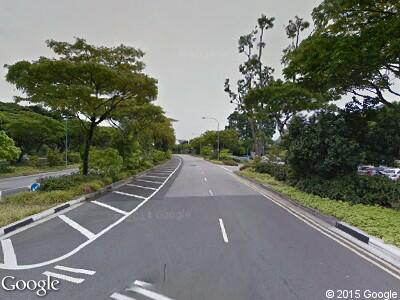

In [7]:
img = 'E:/Dataset/place_pulse_2.0/1.279288_103.870175_50f56099fdc9f065f0005250_Singapore.JPG'
img = Image.open(img)
#img = img.resize((512,512))
img

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_depth.to(device)

def get_depth(img):
    img = img.resize((512,512))
    inputs_d = processor_depth(img, return_tensors="pt").pixel_values.to(device)

    import torch
    with torch.no_grad():
        outputs_d = model_depth(inputs_d)
        predicted_depth = outputs_d.predicted_depth
        predicted_depth.shape
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=inputs_d.shape[-2:],
                        mode="bicubic",
                        align_corners=False,
                ).to(device)
    depth = prediction.squeeze().cpu().numpy()
    # print(depth)
    
    return depth

In [18]:
get_depth(img).shape

(512, 512)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mask.to(device)

def get_mask(img):
    inputs_m = processor_mask(images=img, return_tensors="pt").to(device)
    # inputs_m = {k: v.to(device) for k, v in inputs_m.items()}
    outputs_m = model_mask(**inputs_m)
    predicted_semantic_map = processor_mask.post_process_semantic_segmentation(outputs_m, target_sizes=[img.size[::-1]])[0]
    print(predicted_semantic_map)

    return predicted_semantic_map

In [30]:
get_mask(img)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\Asus\AppData\Local\Temp\ipykernel_22380\664943747.py:1 in <module>                      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\Asus\\AppData\\Local\\Temp\\ipykernel_22380\\664943747.py'                           │
│                                                                                                  │
│ C:\Users\Asus\AppData\Local\Temp\ipykernel_22380\2811467375.py:7 in get_mask                     │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\Asus\\AppData\\Local\\Temp\\ipykernel_22380\\2811467375.py'                          │
│                                                                                                  │
│ d:\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:1501 in _call_impl        │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ d:\anaconda3\envs\pytorch\lib\site-packages\transformers\models\maskformer\modeling_maskformer.p │
│ y:1809 in forward                                                                                │
│                                                                                                  │
│   1806 │   │   )                                                                                 │
│   1807 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│   1808 │   │                                                                                     │
│ ❱ 1809 │   │   outputs: MaskFormerModelOutput = self.model(                                      │
│   1810 │   │   │   pixel_values,                                                                 │
│   1811 │   │   │   pixel_mask,                                                                   │
│   1812 │   │   │   output_hidden_states=output_hidden_states or self.config.use_auxiliary_loss,  │
│                                                                                                  │
│ d:\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:1501 in _call_impl        │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks

In [ ]:
# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["total_pixels"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

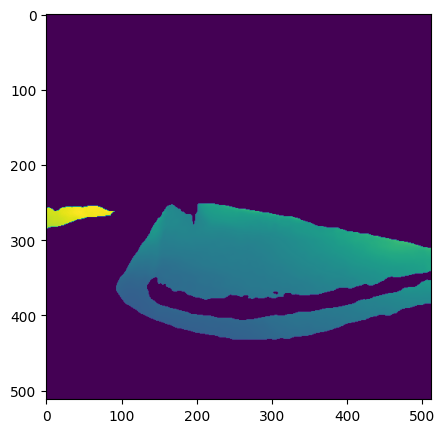

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(prediction * mask)
# plt.savefig("D:/desk/JNU/imgdepth.jpg", dpi = 600)

## Model training

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib
from joblib import Parallel, delayed

In [ ]:
# 从本地读取CSV文件并创建数据帧
data = pd.read_csv('E:/Dataset/perception_restoration/sample.csv')
data.head(2)

X = data.iloc[:,8:] # 自变量x1和x2...
y = data.iloc[:,7] # 因变量y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=5000, 
                            max_depth=15,
                            max_features='sqrt',
                            min_samples_leaf=10,
                            min_samples_split=10,
                            random_state =50)

# 使用5折交叉验证
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 打印均方误差得分
print("Cross-validation scores: ", -cv_scores)
print("Mean score: ", -cv_scores.mean())

# 训练模型
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

### GBDT

In [ ]:
gbdt = GradientBoostingRegressor(loss='huber',          #{'absolute_error', 'huber', 'quantile', 'squared_error'}
                                 learning_rate=0.01,
                                 n_estimators=5000, 
                                 max_depth=15,
                                 max_features='sqrt',
                                 min_samples_leaf=10,
                                 min_samples_split=10,
                                 random_state =50)

# 使用5折交叉验证
cv_scores = cross_val_score(gbdt, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

print("Cross-validation scores: ", -cv_scores)
print("Mean score: ", -cv_scores.mean())

# 训练模型
gbdt.fit(X_train, y_train)

y_pred = gbdt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

Cross-validation scores:  [0.23151949 0.37747859 0.36191425 0.29373943 0.40992215]
Mean score:  0.3349147834984646
MSE: 0.3380088901362872
R-squared: 0.17511149067279308


### XGBoost

In [ ]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", # 损失函数，可以选 "reg:squarederror", "reg:sqrt" 等等
                           learning_rate=0.01,
                           n_estimators=5000,
                           max_depth=15,
                           subsample=0.8, # 每次训练样本的采样比例
                           colsample_bytree=0.8, # 每棵树特征采样比例
                           reg_alpha=0.1, # L1 正则化系数
                           reg_lambda=0.1, # L2 正则化系数
                           random_state=50)

# 使用5折交叉验证
cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 打印均方误差得分
print("Cross-validation scores: ", -cv_scores)
print("Mean score: ", -cv_scores.mean())

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

### KNN

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)

# 使用5折交叉验证
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 打印均方误差得分
print("Cross-validation scores: ", -cv_scores)
print("Mean score: ", -cv_scores.mean())

# 训练模型
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

### Decision Tree

In [ ]:
dt = DecisionTreeRegressor(max_depth=5,
                            max_features='sqrt',
                            min_samples_leaf=10,
                            min_samples_split=10,
                            random_state=50)

# 使用5折交叉验证
cv_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# 打印均方误差得分
print("Cross-validation scores: ", -cv_scores)
print("Mean score: ", -cv_scores.mean())

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

### LR

In [ ]:
lr = LinearRegression()

# 训练模型
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

## Make analysis

### Basic Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data.iloc[:,8:14]

,grass_depth_mean,grass_depth_max,grass_depth_min,tree_depth_mean,tree_depth_max,tree_depth_min
0,1.541427,2.609497,0.998000,1.796533,4.647181,1.008442
1,2.813415,4.722754,1.637505,3.267323,5.810980,2.445102
2,2.879031,4.565498,1.194681,4.002591,5.484296,2.354159
3,2.670372,5.244368,1.496034,3.080829,5.922921,2.113328
4,2.277220,2.979107,1.070643,2.895482,4.895715,1.588969
...,...,...,...,...,...,...
195,2.126567,5.143805,1.061420,3.182721,7.632996,1.617380
196,5.200740,6.452073,4.725192,5.268514,7.223655,3.782614
197,3.828658,4.134098,3.383138,3.799638,5.520790,1.436408
198,1.892354,3.277668,1.497629,3.054503,5.199686,1.865898


[Text(0, 0, 'grass_depth_mean'),
 Text(1, 0, 'grass_depth_max'),
 Text(2, 0, 'grass_depth_min'),
 Text(3, 0, 'tree_depth_mean'),
 Text(4, 0, 'tree_depth_max'),
 Text(5, 0, 'tree_depth_min')]

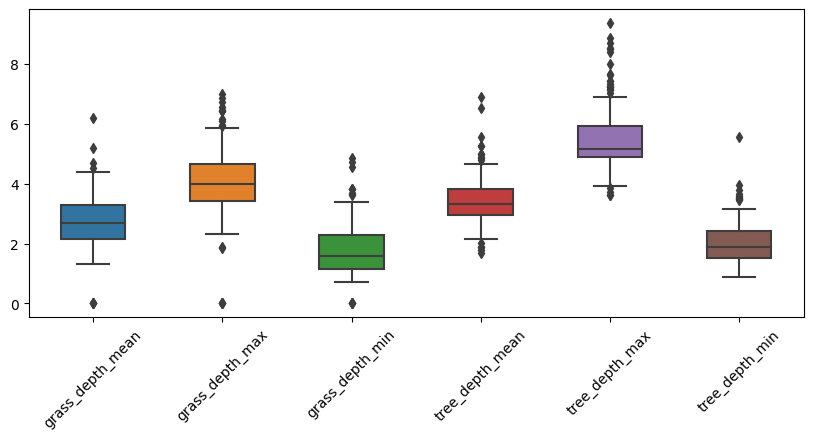

In [ ]:
plt.figure(dpi=100, figsize=(10, 4))

ax=sns.boxplot(data=data.iloc[:,8:14],orient="v",width=0.5,whis=1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

### SHAP

In [ ]:
import shap
shap.initjs()  # notebook环境下，加载用于可视化的JS代码

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
# SHAP Value
explainer = shap.TreeExplainer(gbdt)  # your model
shap_values = explainer(X)

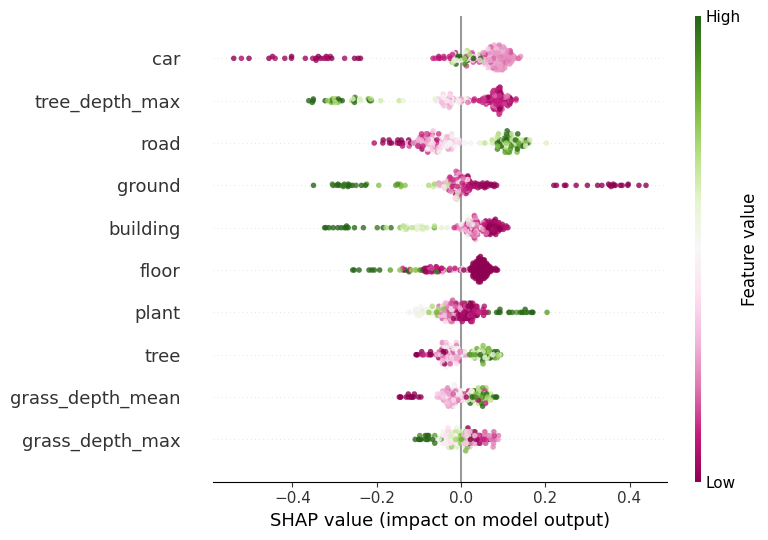

In [ ]:
shap.summary_plot(shap_values, X, max_display=10, alpha=0.8, cmap="PiYG")

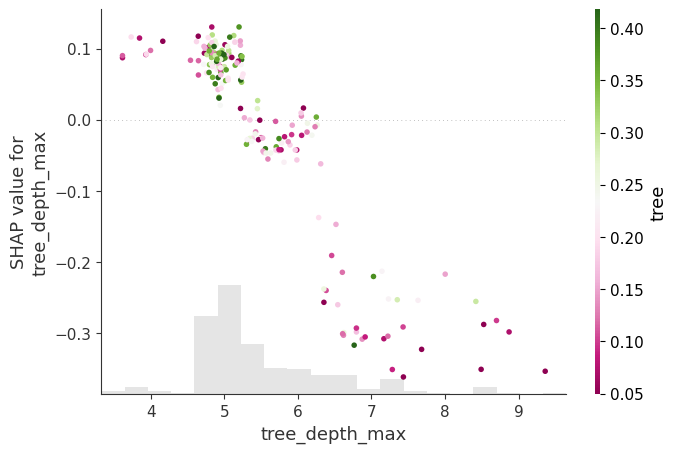

In [ ]:
shap.plots.scatter(shap_values[:, 4], color=shap_values[:, 10], cmap="PiYG")

In [ ]:
shap.plots.bar(shap_values)